<a href="https://colab.research.google.com/github/aanchal0431/chatbot/blob/main/SEP_728_Chatbot_transformer_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.model_selection import train_test_split

In [9]:
print(tf.__version__)

2.7.0


Git Commands to clone repository, pull and push data

In [10]:
!git clone https://github.com/aanchal0431/chatbot.git
#!git pull
%cd chatbot/
#!git config --global user.name "aanchal0431"
#!git config --global user.email "aanchal0431@gmail.com"
#!git remote add aanchal0431 https://github.com/aanchal0431/chatbot.git
#!git --help
#!git remote -v
#!git init
#%ls
#!git add outputs/
!git status 
#!git commit -m 'Model epoch 1'


Cloning into 'chatbot'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 703 (delta 56), reused 178 (delta 35), pack-reused 486
Receiving objects: 100% (703/703), 6.73 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/chatbot/chatbot
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing - **Cleaning**

*   Load datasets
*   Append question and answer datasets
*   Remove questions with no answers
*   Drop irrelevant columns
*   Remove duplicate questions
*   Convert data to lower case
*   Add context

In [12]:
cur_path = 'Data/Question_Answer_Dataset_v1.2/'
data_s8 = pd.read_csv(cur_path + 'S08/question_answer_pairs.txt', delimiter="\t")
data_s9 = pd.read_csv(cur_path + 'S09/question_answer_pairs.txt', delimiter="\t")
data_s10 = pd.read_csv(cur_path + 'S10/question_answer_pairs.txt', delimiter="\t")
print("Shape s8:", data_s8.shape)
print("Shape s9:", data_s9.shape)
print("Shape s10:", data_s10.shape)
data_s8.head()

Shape s8: (1715, 6)
Shape s9: (825, 6)
Shape s10: (1458, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Append Data

In [13]:
#append all questions into one data set
data_all = data_s8.append(data_s9.append(data_s10))
print("Shape:", data_all.shape)
data_all.head()


Shape: (3998, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Drop irrelevant columns and remove questions without an answer

In [14]:
#remove irrelevant columns
data_all = data_all.drop(labels = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis = 1)

#drop rows with NULL values
data_all = data_all.dropna(subset=['Answer'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (3422, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Remove duplicate questions

In [15]:
#remove duplicate questions
data_all = data_all.drop_duplicates(subset=['Question'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (2203, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
4,Abraham_Lincoln,Did his mother die of pneumonia?,no
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832


Convert all text to lower case

In [16]:
# convert text to lower case
data_all = data_all.apply(lambda x: x.astype(str).str.lower())
data_all.head()

,ArticleTitle,Question,Answer
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes
2,abraham_lincoln,did lincoln sign the national banking act of 1...,yes
4,abraham_lincoln,did his mother die of pneumonia?,no
6,abraham_lincoln,how many long was lincoln's formal education?,18 months
8,abraham_lincoln,when did lincoln begin his political career?,1832


Load Wikipedia article and add to the dataframe

In [17]:
#Add a column containing the context
#create dataset with column
title = []
context = []

#pull context and titles from S08
for y in range (8, 11):   
  for s in range(1, 7):
    for a in range(1, 11):
      file = str('Data/Question_Answer_Dataset_v1.2/S0' + str(y) + '/data/set' + str(s) + '/a' + str(a) + '.txt.clean' )
      if os.path.exists(file):
        article = open(file, encoding = "ISO-8859-1").read()
        context.append(article)
        title.append(article.split('\n')[0])

#create dataframe for context and titles
data_articles = pd.DataFrame({'ArticleTitle': title,
                              'Context': context})

#make lower case
data_articles = data_articles.apply(lambda x: x.astype(str).str.lower())

print("Shape:", data_articles.shape)
data_articles.head()

Shape: (90, 2)


,ArticleTitle,Context
0,kangaroo,kangaroo\n\n\na kangaroo is a marsupial from t...
1,leopard,leopard\n\n\n\nthe leopard (panthera pardus) i...
2,penguin,penguin\n\n\n\na penguin encounters a human du...
3,polar bear,polar bear\n\n\n\nthe polar bear (ursus mariti...
4,elephant,elephant\n\n\n\nelephants (elephantidae) are a...


In [18]:
#replace all _ in titles with spaces
data_all['ArticleTitle'] = data_all['ArticleTitle'].str.replace('_', ' ')
data_articles['ArticleTitle'] = data_articles['ArticleTitle'].str.replace('_', ' ')

#join context into data all
data_all = data_all.merge(data_articles, how='left', on='ArticleTitle')

print("Shape:", data_all.shape)
data_all.head()

Shape: (2755, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...


### Explore Data
Check the word length of the answers. How many questions are yes/no questions? What type of question is asked most often?

Single word answers: 1575
Two word answers: 231
Three word answers: 161
Four word answers: 124
Five word answers: 88
6-10 word answers: 341
11-20 word answers: 186
More than 20 words answers: 49

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

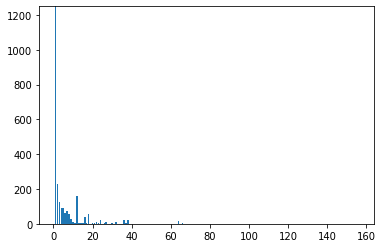

In [19]:
#plot the distribution of answer word length
word_length = data_all['Answer'].str.count(' ') + 1
string_length = data_all['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,1250])
plt.show

In [20]:
#examine types of questions
question_type = data_all['Question'].str.split(' ').str[0]
question_type.value_counts()

what        564
is          395
was         247
how         196
did         193
           ... 
today,        1
forward,      1
at            1
hard          1
hassan        1
Name: Question, Length: 102, dtype: int64

In [21]:
#pull all yes/no questions
yes_no = ['yes', 'yes.', 'yes,', 'no', 'no.', 'no,']
data_yn = data_all.where(data_all['Answer'].str.split(' ').str[0].isin(yes_no)).dropna()
data_yn['Answer'] = data_yn['Answer'].str.split(' ').str[0]

#remove periods & commas
data_yn['Answer'] = data_yn['Answer'].str.replace('.','')
data_yn['Answer'] = data_yn['Answer'].str.replace(',','')

print("Shape:", data_yn.shape)
data_yn.head()

Shape: (1070, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...


In [22]:
#pull all other questions that pull "direct" answers from the context
data_context = data_all.where((data_all['Answer'].str.split(' ').str[0].isin(yes_no)) == False).dropna()
data_context.to_csv('Questions_toClean.csv', index=False)
print("Shape:", data_context.shape)
data_context.head()

Shape: (1252, 4)


,ArticleTitle,Question,Answer,Context
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...
5,abraham lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",abraham lincoln\n\n\n\nabraham lincoln (februa...
6,abraham lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,abraham lincoln\n\n\n\nabraham lincoln (februa...
7,abraham lincoln,when did the gettysburg address argue that ame...,1776,abraham lincoln\n\n\n\nabraham lincoln (februa...


Single word answers: 363
Two word answers: 197
Three word answers: 141
Four word answers: 99
Five word answers: 69
6-10 word answers: 236
11-20 word answers: 116
More than 20 words answers: 31

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

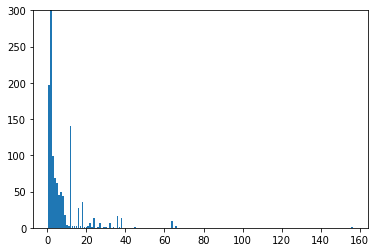

In [23]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Answer'].str.count(' ') + 1
string_length = data_context['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,300])
plt.show

In [24]:
#create type indicator in data set and combine clean yes/no and context
data_yn['Answer Type'] = 'yes/no'
data_context['Answer Type'] = 'context'
data_all = data_yn.append(data_context)

print("Shape:", data_all.shape)
data_all.head()

Shape: (2322, 5)


,ArticleTitle,Question,Answer,Context,Answer Type
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no


<function matplotlib.pyplot.show>

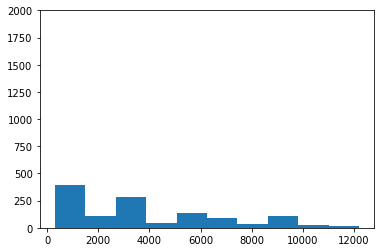

In [25]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Context'].str.count(' ') + 1

plt.hist(word_length, bins = 10)
#plt.bar(word_length.unique(), word_length.value_counts())
#plt.bar(np.arange(90), word_length)
plt.ylim([0,2000])
plt.show

## Transformer (Context Questions)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# segregating questions and answers into different lists
question = list(data_context['Question'])
answer = list(data_context['Answer'])
context = list((data_context['Context']))

input = list(map(lambda q, c: str(q + ' <SEP> ' + c), question, context))
output = list(map(lambda a: str('<START> ' + a + '<END>'), answer))

In [28]:
#initialize the tokenizer
tokenizer = Tokenizer(oov_token="<oov>", char_level = False, lower = True) #oov: out of vocabulary token => used to handle newly encountered words in the training dataset, new

#creating word index
tokenizer.fit_on_texts(input + output)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#create sequences using tokenizer
input_token = tokenizer.texts_to_sequences(input)
output_token = tokenizer.texts_to_sequences(output)

#padding the sequences to make sure length matches for all the sequences
padded_input_tokens = pad_sequences(input_token, padding='post', maxlen = 4000)
padded_output_tokens = pad_sequences(output_token , padding='post', maxlen = 4001)

print("Vocabulary size:", vocab_size)

max_input = padded_input_tokens.shape[1]
print("Max input length:", max_input)

#padded_output_tokens = pad_sequences(output_token , padding='post', maxlen=max_input + 1)

max_output = padded_output_tokens.shape[1]
print("Max answer length:", max_output)

print("Input token shape:", padded_input_tokens.shape)

Vocabulary size: 30655
Max input length: 4000
Max answer length: 4001
Input token shape: (1252, 4000)


In [29]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_input_tokens, padded_output_tokens,
          shuffle=True, test_size=0.1, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
          shuffle=True, test_size=0.2, random_state=5)

In [30]:
def format_dataset(input, answer):
  return ({"encoder_inputs": input, "decoder_inputs": answer[:, :-1],}, answer[:, 1:])

def make_dataset(X, y):
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset = dataset.batch(batch_size=8)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(2048).prefetch(16).cache()
  
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val)
test_ds = make_dataset(X_test, y_test)

In [31]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (8, 4000)
inputs["decoder_inputs"].shape: (8, 4000)
targets.shape: (8, 4000)


In [32]:
from tensorflow import keras
from tensorflow.keras import layers

In [33]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [34]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max_input, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(max_input, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

### Run first 10 epochs

In [36]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 10

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

In [37]:
hist_all = pd.DataFrame(history.history)
hist_all["epoch"] = history.epoch
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')

### Run next 10 epochs

In [35]:
# Load the previously saved weights
#latest = tf.train.latest_checkpoint(checkpoint_dir)
latest = '/content/drive/MyDrive/colab/chatbot/cp-0010.ckpt'

In [36]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

epochs = 10

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [37]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 10
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.012451,0.271972,0.010575,0.303217,0
1,0.010662,0.307527,0.009766,0.327690,1
2,0.010040,0.319224,0.009293,0.333385,2
3,0.009403,0.347853,0.008506,0.363245,3
4,0.008688,0.383869,0.007864,0.405726,4


## Run 10 more

In [ ]:
# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

epochs = 10

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

In [ ]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 20
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

(0.0, 0.02)

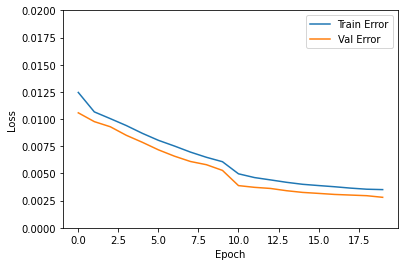

In [38]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,0.02])

## Evaluate

In [ ]:
transformer.evaluate(test_ds)

 10/113 [=>............................] - ETA: 15:45 - loss: 0.0088 - accuracy: 0.3445

KeyboardInterrupt: ignored

## Inference

In [ ]:
word_lookup = list(word_index.keys())
word_lookup.insert(0,'shift')
print(word_lookup)

['shift', '<oov>', 'the', 'of', 'and', 'in', 'a', 'to', 'is', 'as', 'was', 'by', 'for', 'on', 'that', 'with', 'are', 'his', 'he', 'from', 'it', 'at', 'an', 'or', 'which', 'have', 'this', 'be', 'their', 'also', 'not', 'has', 'one', 'other', 'its', 'but', 'most', 'were', 'had', 'some', 'they', 'tesla', 'first', 'more', 'been', 'new', 'two', 'many', 'than', 'after', 'such', 'all', 'there', 'turtles', 'into', 'when', 'used', 'time', 'can', 'these', 'years', 'only', 'world', 'between', 'president', 'known', 'may', 'war', 'who', 'during', 'made', 'about', 'species', 'would', 'national', '1', 'over', 'up', 'while', 'states', 'city', 'government', 'singapore', 'chinese', 'state', 'called', 'use', 'well', 'him', 'faraday', 'them', 'no', 'university', 'however', 'both', 'often', 'language', 'united', '000', 'where', 'american', 'later', 'like', 'three', 'modern', 'lincoln', 'large', 'newton', '2', 'population', 'grant', 'out', 'john', 'through', 'became', 'century', 'i', 'will', '4', 's', 'aroun

In [ ]:
max_decoded_sentence_length = 4000

def decode_sequence(input_text):
    tokenized_input = tokenizer.texts_to_sequences(tf.nest.flatten(input_text))
    tokenized_input = pad_sequences(tokenized_input , padding='post', maxlen = 4000)

    decoded_sentence = "<start>"
    tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
    tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:,:-1]
    
    for i in range(max_decoded_sentence_length):
        predictions = transformer.predict([tokenized_input, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = word_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
        tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:, :-1]
  
        if sampled_token == "<end>":
            break
    return decoded_sentence

In [ ]:
i = 0
input_text = str(question[i] + '<SEP>' + context[i])
actual_answer = answer[i]

tokenized_input = tokenizer.texts_to_sequences(input_text)
tokenized_input = pad_sequences(tokenized_input , padding='post', maxlen = 4000)

bot_answer = decode_sequence(input_text)


print('Question:', question[i])
print('Bot Answer:', bot_answer)
print('\n\nActual Answer', answer[i])

In [ ]:
context_dict = data_context.set_index('ArticleTitle')['Context'].to_dict()
topic_options = data_context['ArticleTitle'].tolist()

# Past Runs

In [ ]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=test_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   9383680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=test_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[